## **Covid-19 Growth Factor by Country **

Please watch the following 9-minute video on exponential growth and the spread of disease...https://www.youtube.com/watch?v=Kas0tIxDvrg

**The versions before version 11 have an error in the computation of the growth factor.**

The versions before Version 16 explored Savitzky–Golay filter (https://en.wikipedia.org/wiki/File:Lissage_sg3_anim.gif) for smoothing data however it seems that that filter is too good at retaining the original trends in data. So here we change to a different smoothing technique.


# **The Math: Exponential vs Logistic**

### The spread of infectious disease can be modeled using a logistic curve rather than an exponential curve. The growth starts exponentially, but must slow down after some point called the **inflection point**. The inflection point is essentially the midpoint of the spread. We will model the number of confirmed cases using a logistic curve. Let's look at the equation for such a curve, the differential equation for which this curve is a solution, and the graph of the curve.

## Logistic Curve Graph

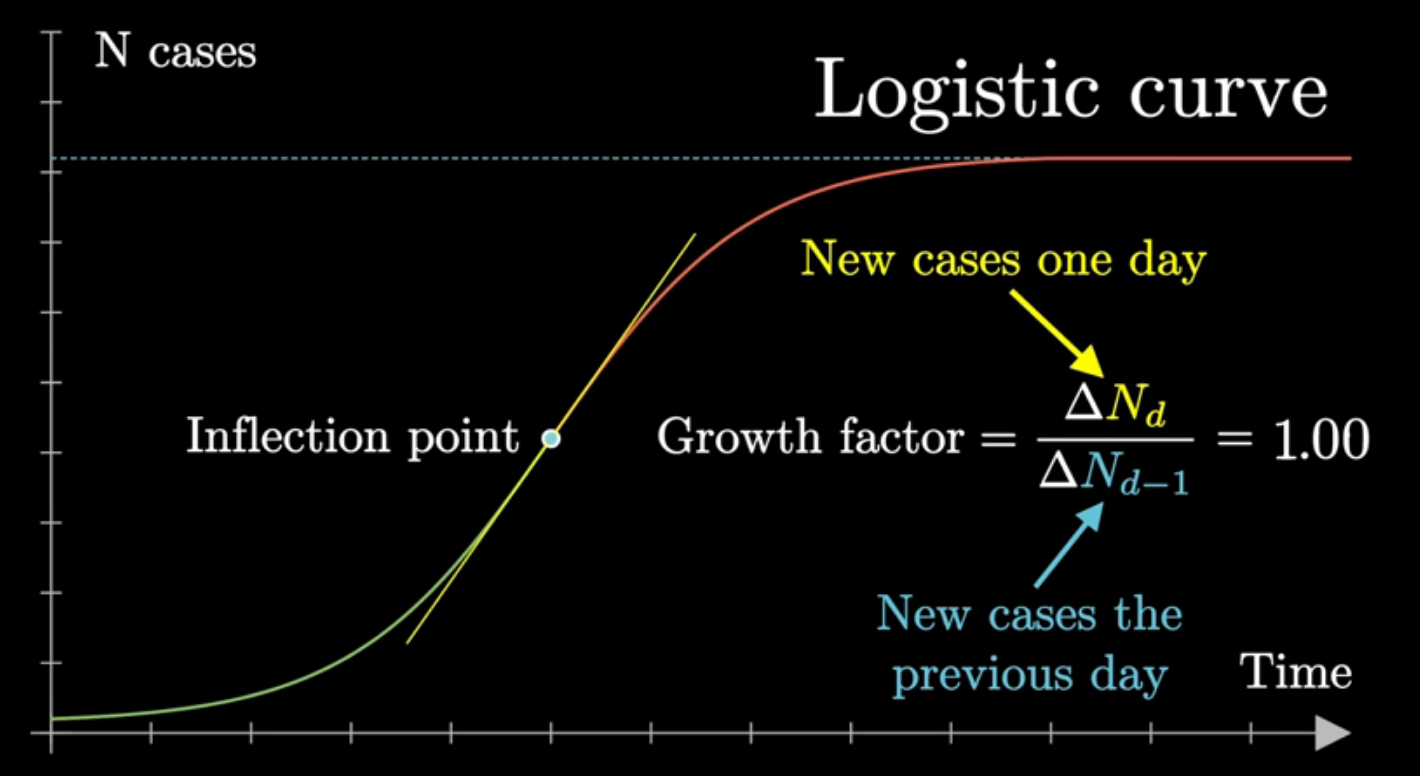

## Logistic Function

### A **logistic function** or **logistic curve** is an equation of the form: 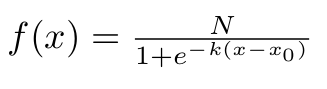
### where

### * x_0 = the inflection point,
### * N = the curve's maximum value, and
### * k = growth rate or steepness of the curve.

For reference: https://en.wikipedia.org/wiki/Logistic_function.
### Actually, the logistic function is just a solution for the following first-order, non-linear ordinary differential equation where f(0) = 0.5: 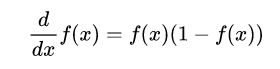

### From the differential equation, stability of solutions and equilibria can be explored. However, let's keep things simple for now and just look at the growth metrics.


# **The Analysis**

### Now that we have seen the math, let's explore the following growth metrics for the confirmed cases for each country:
### * Growth Factor
### * Growth Ratio
### * Growth Rate
### * 2nd Derivative

### We will use these growth metrics to gain insight into which countries may have already hit their inflection points. For example, if a country's growth factor has stabilized around 1.0 then this can be a sign that that country has reached it's inflection point. We will then use curve fitting to fit a logistic curve (similar to the one above) to the number of confirmed cases for each country. This may help us predict if a country has hit their inflection point, and therefore when they will reach a possible maximum number of confirmed cases.

### **Interestingly, the growth factor just tells us the curvature (from Calculus!) of the data.** If we take our data and take the 2nd derivative, basically all it is telling us is whether the cases are growing at an accelerating or decelerating rate. From calculus you may remember we use the 2nd derivative test to test for concavity and find saddle points. The inflection point is where the curve changes concavity. We can look at these growth metrics

### The bigger picture will be to correlate this with preventative efforts such as quarentines, closing of schools, etc. It will also be interesting to see growth factor as a feature in a ML prediction model. I plan on working on this shortly.

## Import Data

In [1]:
# Input data files are available in the "../input/" directory.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv


In [2]:
global_data = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
global_data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0




* Define Active Cases as Confirmed minus Recovered minus Deaths.
* Drop SNo, Province/State, and Last Update.
* Plot Active, Confirmed, and Recovered Cases, Deaths, Growth Factor, 2nd_Derivative, and Growth Ratio

The **growth factor** on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.

The **growth ratio** on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.

Special thanks to Dan Pearson for the smoother function below, and for cleaning some of the code.

In [3]:
# This functions smooths data, thanks to Dan Pearson. We will use it to smooth the data for growth factor.
def smoother(inputdata,w,imax):
    data = 1.0*inputdata
    data = data.replace(np.nan,1)
    data = data.replace(np.inf,1)
    #print(data)
    smoothed = 1.0*data
    normalization = 1
    for i in range(-imax,imax+1):
        if i==0:
            continue
        smoothed += (w**abs(i))*data.shift(i,axis=0)
        normalization += w**abs(i)
    smoothed /= normalization
    return smoothed

def growth_factor(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    confirmed_iminus2 = confirmed.shift(2, axis=0)
    return (confirmed-confirmed_iminus1)/(confirmed_iminus1-confirmed_iminus2)

def growth_ratio(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return (confirmed/confirmed_iminus1)

# This is a function which plots (for in input country) the active, confirmed, and recovered cases, deaths, and the growth factor.
def plot_country_active_confirmed_recovered(country):
    
    # Plots Active, Confirmed, and Recovered Cases. Also plots deaths.
    country_data = global_data[global_data['Country/Region']==country]
    table = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
    table['ActiveCases'] = table['Confirmed'] - table['Recovered'] - table['Deaths']
    table2 = pd.pivot_table(table, values=['ActiveCases','Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
    table3 = table2.drop(['Deaths'], axis=1)
   
    # Growth Factor
    w = 0.5
    table2['GrowthFactor'] = growth_factor(table2['Confirmed'])
    table2['GrowthFactor'] = smoother(table2['GrowthFactor'],w,5)

    # 2nd Derivative
    table2['2nd_Derivative'] = np.gradient(np.gradient(table2['Confirmed'])) #2nd derivative
    table2['2nd_Derivative'] = smoother(table2['2nd_Derivative'],w,7)


    #Plot confirmed[i]/confirmed[i-1], this is called the growth ratio
    table2['GrowthRatio'] = growth_ratio(table2['Confirmed'])
    table2['GrowthRatio'] = smoother(table2['GrowthRatio'],w,5)
    
    #Plot the growth rate, we will define this as k in the logistic function presented at the beginning of this notebook.
    table2['GrowthRate']=np.gradient(np.log(table2['Confirmed']))
    table2['GrowthRate'] = smoother(table2['GrowthRate'],0.5,3)
    
    # horizontal line at growth rate 1.0 for reference
    x_coordinates = [1, 100]
    y_coordinates = [1, 1]
    #plots
    table2['Deaths'].plot(title='Deaths')
    plt.show()
    table3.plot() 
    plt.show()
    table2['GrowthFactor'].plot(title='Growth Factor')
    plt.plot(x_coordinates, y_coordinates) 
    plt.show()
    table2['2nd_Derivative'].plot(title='2nd_Derivative')
    plt.show()
    table2['GrowthRatio'].plot(title='Growth Ratio')
    plt.plot(x_coordinates, y_coordinates)
    plt.show()
    table2['GrowthRate'].plot(title='Growth Rate')
    plt.show()


    return 


## China

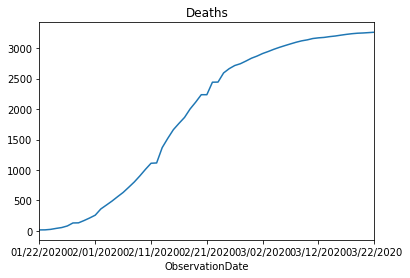

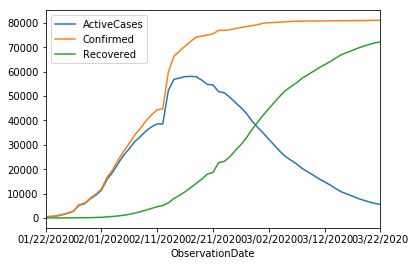

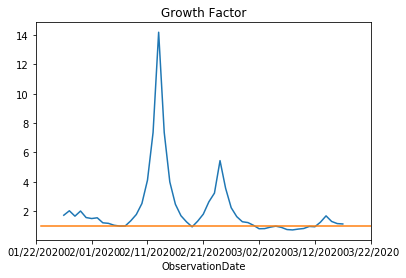

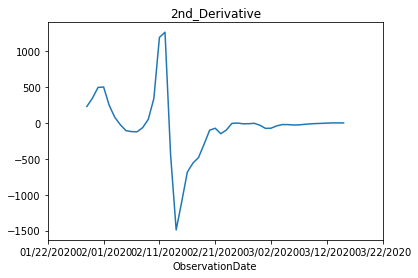

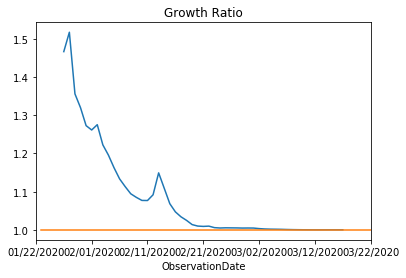

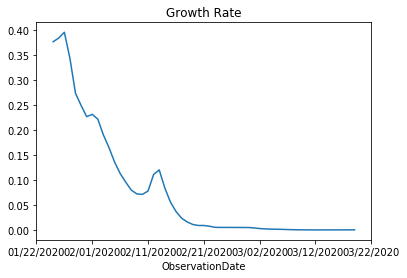

In [4]:
plot_country_active_confirmed_recovered('Mainland China')

We see a dramatic decrease in growth ratio and growth factor for china, until it stabilizes around 1.0.

What's also interesting is that we see that China's confirmed curve and recovered curve already resemble a logistic curve. We should be able to estimate an inflection point for China, and as you will see South Korea. We can maybe then use these to build a model to predict countries like Italy, Germany, Spain, and the United States. Future versions of this kernel will explore this.

## South Korea

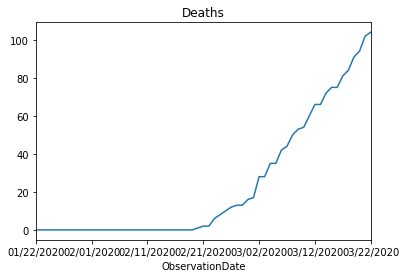

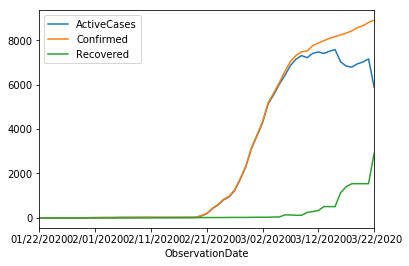

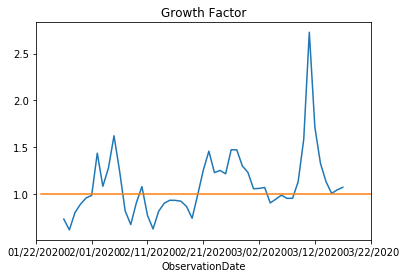

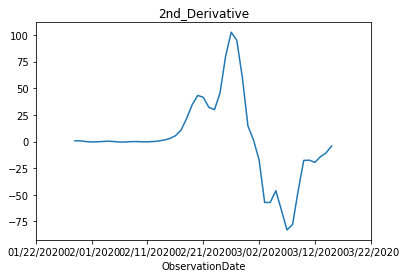

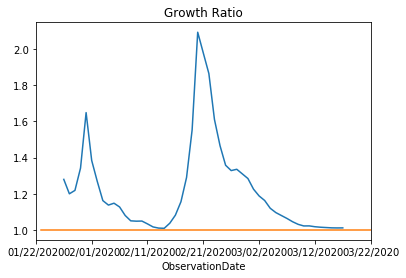

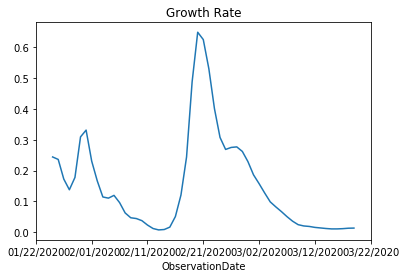

In [5]:
plot_country_active_confirmed_recovered('South Korea')

## US

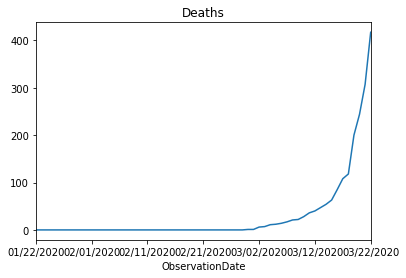

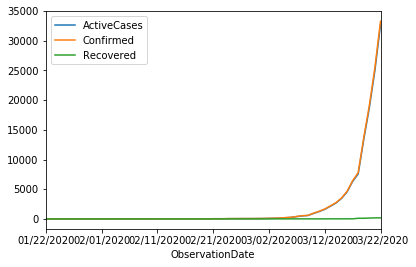

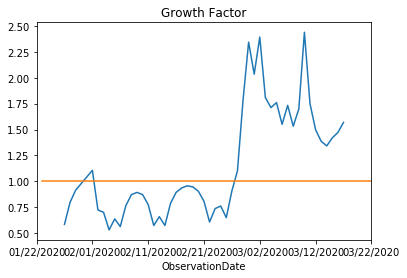

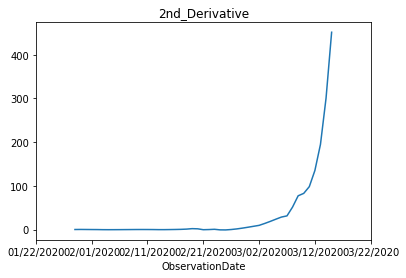

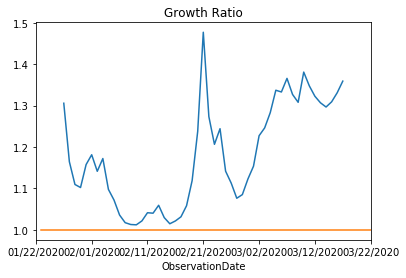

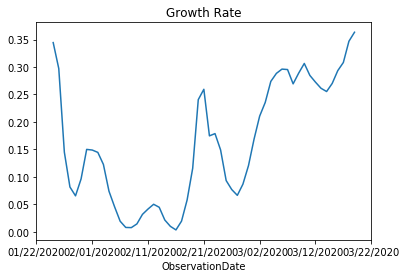

In [6]:
plot_country_active_confirmed_recovered('US')


## Germany

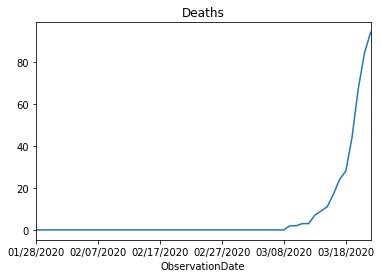

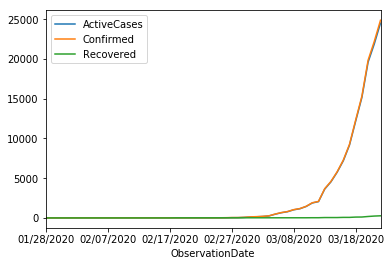

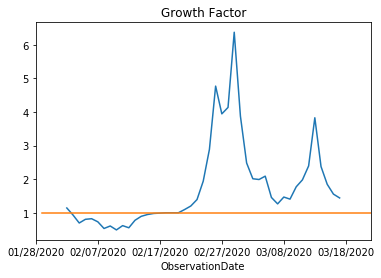

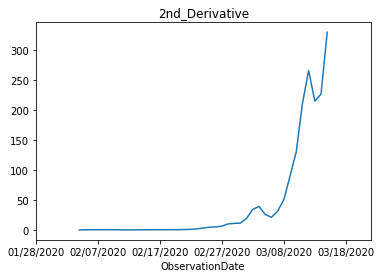

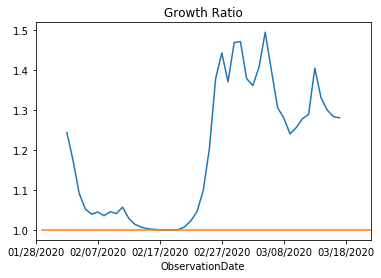

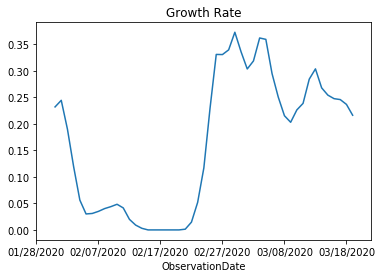

In [7]:
plot_country_active_confirmed_recovered('Germany')

## Italy

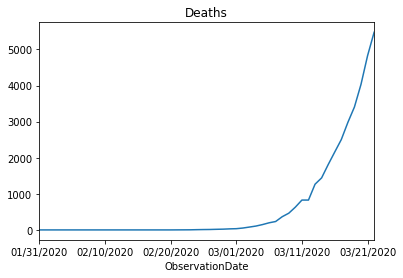

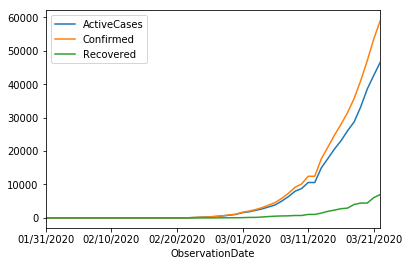

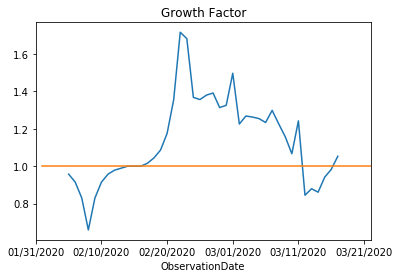

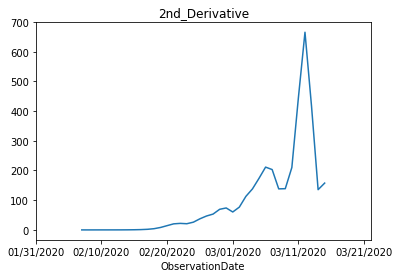

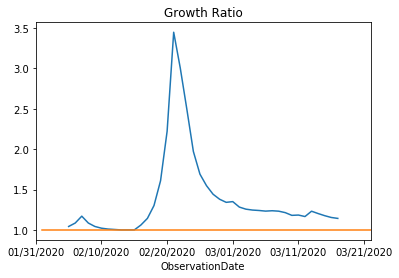

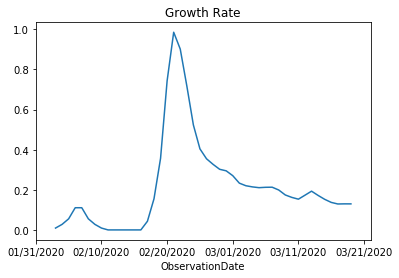

In [8]:
plot_country_active_confirmed_recovered('Italy')

Let's now compare China with the rest of the world.

## Rest of the World

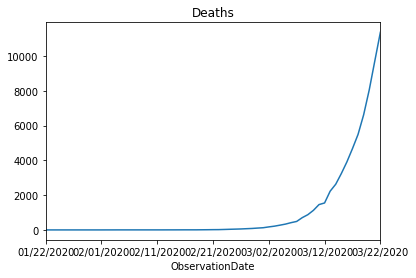

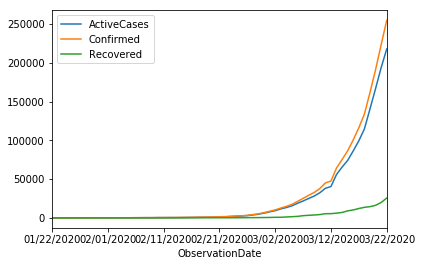

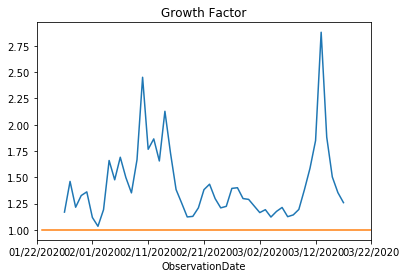

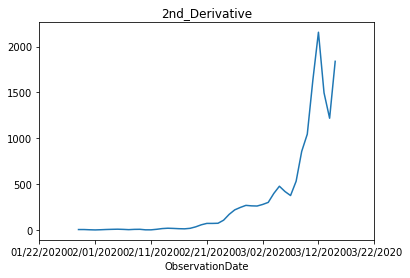

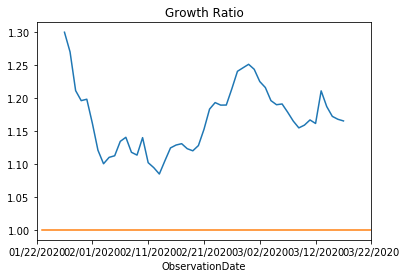

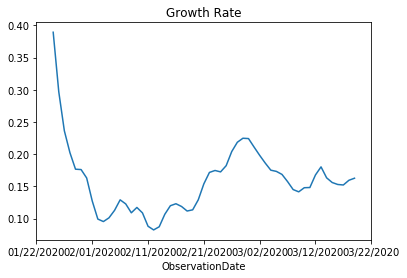

In [9]:
restofworld_data = global_data
for country in restofworld_data['Country/Region']:
    if country != 'Mainland China': 
        restofworld_data['Country/Region'] = restofworld_data['Country/Region'].replace(country, "RestOfWorld")

plot_country_active_confirmed_recovered('RestOfWorld')


## Smoothed vs Unsmoothed Growth Factor

The growth factor we see above for Rest Of World is smoothed, just for illustration, let's look at smoothed vs unsmoothed.

The orange plot is the unsmoothed growth factor data for all countries except for china, the blue is the smoothed data. Smoothed data is essentially a weighted average, you can see how we define it above.

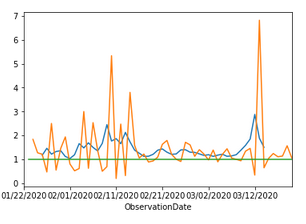

## Logistic Curve Fitting

Now that things are smooth, we can fit :-)

We are going to use scipy.optimize.curve_fit to fit a logistic curve to the number of confirmed cases in China and South Korea.

In [10]:
from scipy.optimize import curve_fit


In [11]:
# We want number of confirmed for each date for each country
#country_data = global_data[global_data['Country/Region']=='Mainland China']
global_data = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
country_data = global_data[global_data['Country/Region']=='Italy']
country_data = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
country_data = pd.pivot_table(country_data, values=['Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
country_data.tail()

,Confirmed,Deaths,Recovered
ObservationDate,,,
03/18/2020,35713.0,2978.0,4025.0
03/19/2020,41035.0,3405.0,4440.0
03/20/2020,47021.0,4032.0,4440.0
03/21/2020,53578.0,4825.0,6072.0
03/22/2020,59138.0,5476.0,7024.0


In [12]:
#country_data['GrowthFactor'] = growth_factor(country_data['Confirmed'])

# we will want x_data to be the number of days since first confirmed and the y_data to be the confirmed data. This will be the data we use to fit a logistic curve
x_data = range(len(country_data.index))
y_data = country_data['Confirmed']

def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

# Fit the curve
popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf), maxfev=5000)
estimated_k, estimated_x_0, ymax= popt


# Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0
y_fitted = log_curve(x_data, k, x_0, ymax)
print(k, x_0, ymax)
#print(y_fitted)
y_data.tail()

0.19576502968821027 51.1827575012312 119874.64844661896


ObservationDate
03/18/2020    35713.0
03/19/2020    41035.0
03/20/2020    47021.0
03/21/2020    53578.0
03/22/2020    59138.0
Name: Confirmed, dtype: float64

### Notice that this predicts Italy hits the inflection point is around day 51 and the number of confirmed cases will max out around 119,874 cases.

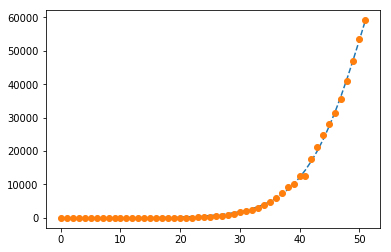

In [13]:
# Plot everything for illustration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_data, y_fitted, '--', label='fitted')
ax.plot(x_data, y_data, 'o', label='Confirmed Data')


# We see here that this predicts that Italy is currently near it's inflection point and should max out around 119,874 confirmed cases. For China and South Korea, the curve underestimated. So this is probably also the case here. Furthermore, for some countries, it is too early to use this method to get a reasonable estimate. For example it is too early for India and the US. *As of March 22nd.